Grounding DINO

The Grounding DINO model was proposed in Grounding DINO: Marrying DINO with Grounded Pre-Training for Open-Set Object Detection by Shilong Liu, Zhaoyang Zeng, Tianhe Ren, Feng Li, Hao Zhang, Jie Yang, Chunyuan Li, Jianwei Yang, Hang Su, Jun Zhu, Lei Zhang. Grounding DINO extends a closed-set object detection model with a text encoder, enabling open-set object detection. The model achieves remarkable results, such as 52.5 AP on COCO zero-shot.

The abstract from the paper is the following:

In this paper, we present an open-set object detector, called Grounding DINO, by marrying Transformer-based detector DINO with grounded pre-training, which can detect arbitrary objects with human inputs such as category names or referring expressions. The key solution of open-set object detection is introducing language to a closed-set detector for open-set concept generalization. To effectively fuse language and vision modalities, we conceptually divide a closed-set detector into three phases and propose a tight fusion solution, which includes a feature enhancer, a language-guided query selection, and a cross-modality decoder for cross-modality fusion. While previous works mainly evaluate open-set object detection on novel categories, we propose to also perform evaluations on referring expression comprehension for objects specified with attributes. Grounding DINO performs remarkably well on all three settings, including benchmarks on COCO, LVIS, ODinW, and RefCOCO/+/g. Grounding DINO achieves a 52.5 AP on the COCO detection zero-shot transfer benchmark, i.e., without any training data from COCO. It sets a new record on the ODinW zero-shot benchmark with a mean 26.1 AP.



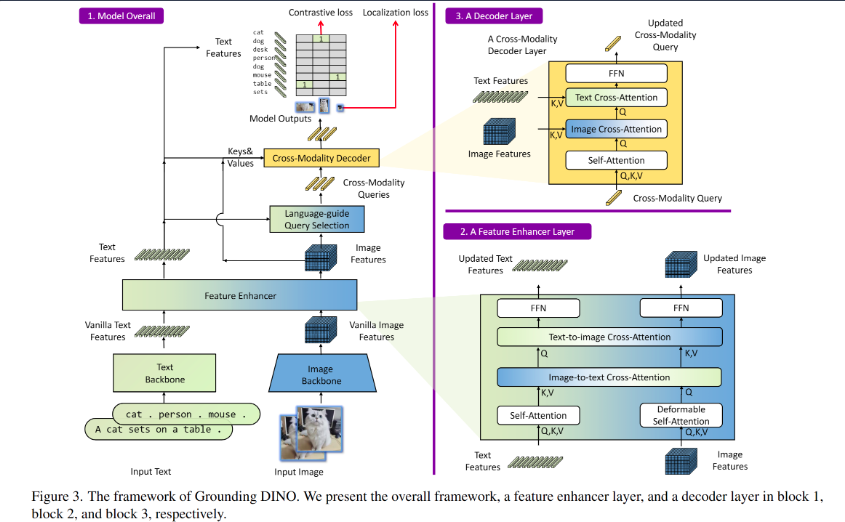

In [1]:
# https://arxiv.org/abs/2303.05499

In [2]:
import requests
import torch
from PIL import Image
import numpy as np
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model_id_dino = "IDEA-Research/grounding-dino-tiny"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor_dino = AutoProcessor.from_pretrained(model_id_dino)
model_dino = AutoModelForZeroShotObjectDetection.from_pretrained(model_id_dino).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
def calculate_bounding_box_areas_dino(bounding_boxes):
    areas = []
    for box in bounding_boxes:
      if len(box) == 0:
        areas.append(0)
      else:
        x1, y1, x2, y2 = box

        # Calculate width and height of the bounding box
        width = abs(x2 - x1)
        height = abs(y2 - y1)

        # Calculate area
        area = width * height
        areas.append(area // 1000)

    return areas

In [4]:
def get_bounding_boxes_dino(image_path, text="a spyder man."):
  image = Image.open(image_path).convert('RGB')

  # Text prompt for detection
  # text = "a spyder man."

  # Process inputs
  inputs = processor_dino(images=image, text=text, return_tensors="pt").to(device)

  # Run inference
  with torch.no_grad():
      outputs = model_dino(**inputs)

  # Post-process results
  results = processor_dino.post_process_grounded_object_detection(
      outputs,
      inputs.input_ids,
      box_threshold=0.4,
      text_threshold=0.3,
      target_sizes=[image.size[::-1]]
  )[0]  # Get first (and only) image results

  boxes = []

  if len(results['boxes']) == 0:
      return [], 0

  # Print results in a more readable format
  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]


    if len(results) <= 1:
      return box, calculate_bounding_box_areas_dino(box)[0]
    else:
      # Do the max thing
      boxes.append(box)

  areas = calculate_bounding_box_areas_dino(boxes)
  index_of_max = max(range(len(areas)), key=lambda i: areas[i])
  return boxes[index_of_max], areas[index_of_max]

In [18]:
def calculate_center_dino(box):
  if len(box) == 0:
    return (0, 0)
  x1, y1, x2, y2 = box

  # Calculate width and height of the bounding box
  width = abs(x2 - x1)
  height = abs(y2 - y1)

  # Calculate area
  area = width * height

  # Calculate center
  center_x = int((x1 + x2) / 2)
  center_y = int((y1 + y2) / 2)
  return (center_x, center_y)

In [6]:
get_bounding_boxes_dino('/content/sp_1.png', 'a spiderman.')

([792.76, 243.74, 1089.42, 503.03], 76.0)

In [7]:
def get_max_info_frame_dino(image_paths, texts):
    if isinstance(texts, str):
        texts = [texts]

    cumulative_areas = []
    all_boxes = []
    all_centers = []

    for img in image_paths:
        total_area = 0
        best_box = []
        best_center = []
        for text in texts:
            box, area = get_bounding_boxes_dino(img, text)
            if box is not None:
                total_area += area
                center = calculate_center_dino(box)

                best_box.append(box)
                best_center.append(center)
            else:
                best_box.append([])
                best_center.append([])

        cumulative_areas.append(total_area)
        all_boxes.append(best_box if best_box else [])
        all_centers.append(best_center if best_center else [])

    index_of_max = max(range(len(cumulative_areas)), key=lambda i: cumulative_areas[i])
    return image_paths[index_of_max], all_boxes[index_of_max], all_centers[index_of_max]

In [19]:
frame_path, boxes, centers = get_max_info_frame_dino(image_paths=['/content/sp_1.png', '/content/sp_2.png', '/content/sp_3.png'], texts=['a spyder man.'])
print(frame_path, boxes, centers)

/content/sp_1.png [[1.96, 127.85, 756.04, 503.55]] [(379, 315)]


In [20]:
frame_path, boxes, centers = get_max_info_frame_dino(image_paths=['/content/fc_1.png', '/content/fc_2.png'], texts=['a f1 car on road.', 'a flying car.'])
print(frame_path, boxes, centers)

/content/fc_1.png [[475.95, 438.83, 748.5, 509.2], [475.77, 124.7, 816.84, 324.6]] [(612, 474), (646, 224)]


In [10]:
# solu = [[498.15, 58.98, 771.37, 501.62],

# [5.44, 2.08, 1304.45, 503.25],
# [994.37, 1.81, 1311.06, 503.43],

# [337.68, 0.72, 852.02, 463.51],

# [550.7, 0.66, 835.19, 270.17],

# [162.42, 14.93, 1051.08, 503.37],

# [1036.0, 0.8, 1214.79, 178.2],

# [792.94, 244.29, 1089.56, 503.55],
# [1.96, 127.85, 756.04, 503.55]]

# areas = calculate_bounding_box_areas(solu)
# print("Areas of bounding boxes:", areas)

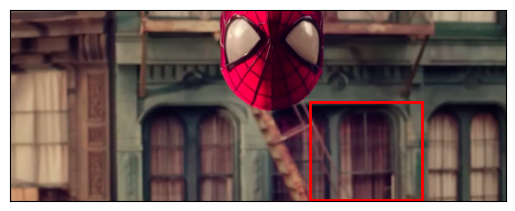

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load the image
image_path = "/content/sp_1.png"
image = Image.open(image_path)

# Create figure and axis
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Create a rectangle patch
# Format: [x, y, width, height]
box = [792.76, 243.74, 1089.42, 503.03]
x, y, x2, y2 = box
width = x2 - x
height = y2 - y

# Create a rectangle patch
rect = patches.Rectangle(
    (x, y),
    width,
    height,
    linewidth=2,
    edgecolor='r',
    facecolor='none'
)

# Add the rectangle to the plot
ax.add_patch(rect)

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])

# Display the plot
plt.show()

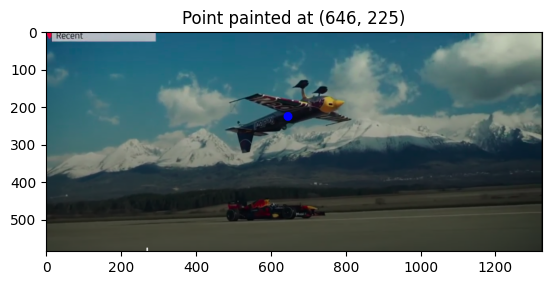

In [13]:
import cv2
import matplotlib.pyplot as plt

def paint_point_on_image(image_path, x, y, output_path=None, point_color=(255, 0, 0), point_radius=12):
    import cv2
    import matplotlib.pyplot as plt

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return

    # Paint the point on the image
    cv2.circle(image, (x, y), radius=point_radius, color=point_color, thickness=-1)

    # Convert to RGB for displaying in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib
    plt.imshow(image_rgb)
    plt.axis('on')
    plt.title(f"Point painted at ({x}, {y})")
    plt.show()

    # Save the image if an output path is provided
    if output_path:
        cv2.imwrite(output_path, image)

# Example usage
image_path = "/content/fc_1.png"
x = 646  # X-coordinate
y = 225  # Y-coordinate
output_path = "/content/image_with_point.png"  # Optional: Path to save the output image

paint_point_on_image(image_path, x, y, output_path)
